# Geopandas Example #4: Buffers & Point Data Intersect

This example uses data on the Woolsey Fire (November 2018, near Los Angeles) and Mobile Home Park locations. 

<b>This is a geopandas example covering the following:</b>

1. Plotting California counties, fire boundaries, and mobile home locations
2. Intersection of mobile home locations & fire boundaries
    - (point-polygon intersection with multiple separate polygon geodataframes)
3. Intersection of mobile home locations & county centroid buffers
    -  (point-polygon intersection with single geodataframe of multiple polygons)

California typically experiences a number of fires each year. 2018 was an especially destructive year, and fires such as [the Woolsey Fire](https://www.latimes.com/local/lanow/la-me-woolsey-resources-20190106-htmlstory.html) in Los Angeles/Ventura County and [the Camp Fire](https://www.nytimes.com/interactive/2019/07/31/magazine/paradise-camp-fire-california.html) north of San Francisco made national headlines. The Camp Fire was especially tragic becaue it was particularly quick-moving and caused over 80 deaths. Many fatalities in the Camp Fire were of elderly people in mobile home parks who had limited mobility ([L.A. Times](https://www.latimes.com/local/lanow/la-me-ln-camp-fire-seniors-mobile-home-deaths-20190209-story.html)).
    
After reading more about the 2018 California fires, I was interested in doing some geographic analysis using fire-related data. The U.S. Geological Society publishes data on fire boundaries. The U.S. Department of Homeland Security publishes infrastructure data, including mobile home locations. I used both of these datasets to explore the Woolsey fire and mobile home locations in the broader Los Angeles area.

In [1]:
# usual packages
import os
import pandas as pd
import numpy as np

In [2]:
# map-related packages
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import fiona

In [3]:
# set working directory
working_dir = '/Users/sarahrunkle/Desktop/git_desktop/'
os.chdir(working_dir)

## Read in Data & Convert Projection to UTM 11

In [4]:
# read in the states data
# https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.2017.html
states_file = working_dir + '/geo_data/states/states_cb_2017/cb_2017_us_state_500k.shp'
states_orig = gpd.read_file(states_file)

In [5]:
# convert states to UTM zone 11
states = states_orig.to_crs({'init': 'epsg:26911'})

In [6]:
# add in counties
counties_orig = working_dir + '/geo_data/counties/tl_2019_us_county/tl_2019_us_county.shp'
counties_orig = gpd.read_file(counties_orig)

In [8]:
# convert to UTM zone 11
counties = counties_orig.to_crs({'init': 'epsg:26911'})

In [9]:
# Woolsey Fire (near L.A., November 2018)
# https://rmgsc.cr.usgs.gov/outgoing/GeoMAC/2018_fire_data/California/Woolsey/
woolsey_1109 = working_dir + '/geo_data/fire_boundaries/ca_woolsey_20181109_1746_dd83/ca_woolsey_20181109_1746_dd83.shp'
woolsey_1109 = gpd.read_file(woolsey_1109)  

woolsey_1110 = working_dir + '/geo_data/fire_boundaries/ca_woolsey_20181110_0405_dd83/ca_woolsey_20181110_0405_dd83.shp'
woolsey_1110 = gpd.read_file(woolsey_1110)  

woolsey_1118 = working_dir + '/geo_data/fire_boundaries/ca_woolsey_20181118_0559_dd83/ca_woolsey_20181118_0559_dd83.shp'
woolsey_1118 = gpd.read_file(woolsey_1118)  

In [10]:
# convert to UTM zone 11
woolsey_1109 = woolsey_1109.to_crs({'init': 'epsg:26911'})
woolsey_1110 = woolsey_1110.to_crs({'init': 'epsg:26911'})
woolsey_1118 = woolsey_1118.to_crs({'init': 'epsg:26911'})

In [11]:
# mobile home park data
# https://hifld-geoplatform.opendata.arcgis.com/datasets/mobile-home-parks
homes_orig = working_dir + '/geo_data/Mobile_Home_Parks/Mobile_Home_Parks.shp'
homes_orig = gpd.read_file(homes_orig)  

In [12]:
# convert to UTM zone 11
homes = homes_orig.to_crs({'init': 'epsg:26911'})

## Subset Data to Necessary Columns

In [13]:
# check out states columns
list(states)

['STATEFP',
 'STATENS',
 'AFFGEOID',
 'GEOID',
 'STUSPS',
 'NAME',
 'LSAD',
 'ALAND',
 'AWATER',
 'geometry']

In [14]:
# states data shape
states.shape

(56, 10)

In [15]:
# subset states to just california
cal = states.loc[states_orig['STUSPS']=='CA']
cal.shape

(1, 10)

In [16]:
# check out counties columns
list(counties)

['STATEFP',
 'COUNTYFP',
 'COUNTYNS',
 'GEOID',
 'NAME',
 'NAMELSAD',
 'LSAD',
 'CLASSFP',
 'MTFCC',
 'CSAFP',
 'CBSAFP',
 'METDIVFP',
 'FUNCSTAT',
 'ALAND',
 'AWATER',
 'INTPTLAT',
 'INTPTLON',
 'geometry']

In [17]:
# counties data shape
counties.shape

(3233, 18)

In [18]:
# subset counties to just those near LA
counties_list = ['Kern', 'Los Angeles', 'Santa Barbara', 'Ventura']
counties_cal = counties.loc[counties['NAME'].isin(counties_list)]
counties_cal.shape

(4, 18)

In [19]:
# check out counties data
list(counties_cal)

['STATEFP',
 'COUNTYFP',
 'COUNTYNS',
 'GEOID',
 'NAME',
 'NAMELSAD',
 'LSAD',
 'CLASSFP',
 'MTFCC',
 'CSAFP',
 'CBSAFP',
 'METDIVFP',
 'FUNCSTAT',
 'ALAND',
 'AWATER',
 'INTPTLAT',
 'INTPTLON',
 'geometry']

In [20]:
# subset to necessary columns
counties_cal = counties_cal[['GEOID', 'NAME', 'INTPTLAT', 'INTPTLON', 'geometry']]
counties_cal = counties_cal.rename(columns={'INTPTLAT':'Lat',
                                            'INTPTLON':'Long'})

In [21]:
# check out fire data
list(woolsey_1109)

['OBJECTID',
 'SHAPE_Area',
 'irwinid',
 'mapmethod',
 'unitIDProt',
 'unitIDOwn',
 'incidentID',
 'fireName',
 'perDatTime',
 'comments',
 'agency',
 'active',
 'latest',
 'compParID',
 'fireYear',
 'dateCrnt',
 'inciwebId',
 'firecode',
 'mergeid',
 'compfirecd',
 'fireNum',
 'ComplexNm',
 'state',
 'inComplex',
 'GISACRES',
 'geometry']

In [22]:
# check out fire data
woolsey_1109.shape

(1, 26)

In [23]:
# check out fire data
woolsey_1109

,OBJECTID,SHAPE_Area,irwinid,mapmethod,unitIDProt,unitIDOwn,incidentID,fireName,perDatTime,comments,...,inciwebId,firecode,mergeid,compfirecd,fireNum,ComplexNm,state,inComplex,GISACRES,geometry
0,2,0.003751,{FB1BA090-BA1A-48B6-981E-E4CE521A7AFB},Mixed Methods,CAVNC,CAVNC,2018-CAVNC-091023,WOOLSEY,11/9/2018 5:46:00 PM,None,...,None,L6B3,None,None,091023,None,CA,N,9478.312741,"POLYGON ((335517.2115729002 3785550.372008564,..."


In [24]:
# subset to necessary columns
woolsey_1109 = woolsey_1109[['fireName', 'perDatTime', 'geometry']]
woolsey_1110 = woolsey_1110[['fireName', 'perDatTime', 'geometry']]
woolsey_1118 = woolsey_1118[['fireName', 'perDatTime', 'geometry']]

In [25]:
# check out mobile homes data
list(homes)

['OBJECTID',
 'MHPID',
 'NAME',
 'ADDRESS',
 'CITY',
 'STATE',
 'ZIP',
 'ZIP4',
 'TELEPHONE',
 'TYPE',
 'STATUS',
 'COUNTY',
 'COUNTYFIPS',
 'COUNTRY',
 'LATITUDE',
 'LONGITUDE',
 'NAICS_CODE',
 'NAICS_DESC',
 'SOURCE',
 'SOURCEDATE',
 'VAL_METHOD',
 'VAL_DATE',
 'WEBSITE',
 'UNITS',
 'SIZE',
 'REVGEOFLAG',
 'geometry']

In [26]:
# check out mobile homes data
homes.shape

(45642, 27)

In [27]:
# mobile homes counties
homes['COUNTY'].head()

0     ORANGE
1     ORANGE
2     ORANGE
3     ORANGE
4    CAMERON
Name: COUNTY, dtype: object

In [28]:
# cut down to just those mobile homes in same counties
counties_list = ['KERN', 'LOS ANGELES', 'SANTA BARBARA', 'VENTURA']
homes = homes.loc[homes['COUNTY'].isin(counties_list)]
homes.shape

(968, 27)

In [29]:
# subset mobile homes data
homes = homes[['MHPID', 'NAME', 'geometry']]
homes = homes.rename(columns={'MHPID':'MH_ID',
                              'NAME':'MH_Name'})
homes.shape

(968, 3)

## Set up Functions for Use Later

In [30]:
# create a function to plot basic map of california
# this will be used frequently throughout examples below
def plot_basic_map(title):
    # create figure and axes
    fig, ax = plt.subplots(1, figsize=(16,12))
    # get rid of axis marks
    ax.axis('off')
    # add cal data
    cal.plot(ax=ax,
             color='#b3cce6',
             linewidth=2.0,
              edgecolor='#0086b3')
    # set title of map based on function input
    ax.set_title(title, fontsize=20)
    
    return fig

In [31]:
# map function for bounds
# note this works specifically for the UTM bounds
def map_bounds(geography, padding):    
    # get the total bounds of the geography
    min_x, min_y, max_x, max_y = geography.total_bounds
    
    # transform bounds
    min_x = min_x*(1+padding)
    min_y = min_y*(1-padding)
    max_x = max_x*(1-padding)
    max_y = max_y*(1+padding)
    
    return min_x, min_y, max_x, max_y

In [32]:
# buffer meters
def buffer_meters(miles):
    buffer_meters = miles*1609.344
    
    return buffer_meters

## Make Some Initial Maps

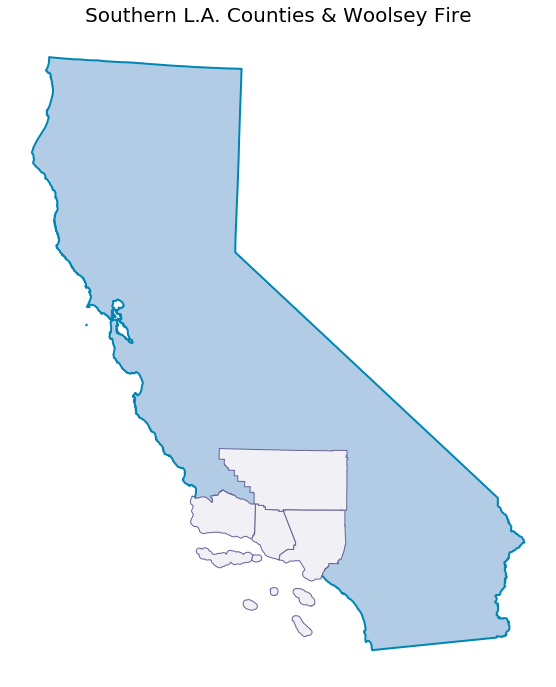

In [33]:
map1 = plot_basic_map('Southern L.A. Counties & Woolsey Fire')

# add southern CA counties
counties_cal.plot(ax=map1.gca(),
                  color='#f0f0f5',
                  linewidth=1.0,
                  edgecolor='#666699')

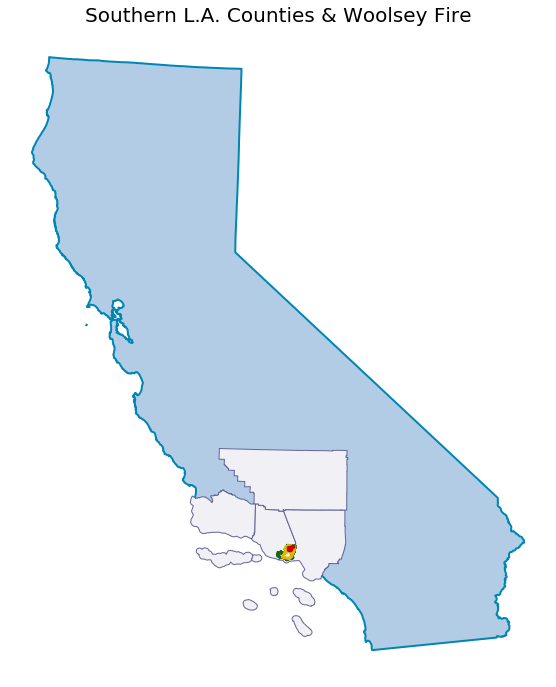

<Figure size 432x288 with 0 Axes>

In [34]:
# add the fire data in

# green boundary (2018-11-18 data, when fire contained)
woolsey_1118.plot(ax=map1.gca(),
                  color='#ffffff00',
                  linewidth=3.0,
                  edgecolor='#196619')

# yellow boundary (2018-11-10 data)
woolsey_1110.plot(ax=map1.gca(),
                  color='#ffffff00',
                  linewidth=3.0,
                  edgecolor='#e6b800')

# red boundary (2018-11-09 data, when fire started)
woolsey_1109.plot(ax=map1.gca(),
                  color='#ffffff00',
                  linewidth=3.0,
                  edgecolor='#cc0000')
map1

Because the Woolsey fire burned for almost two weeks, I was interested in looking at the fire boundaries over multiple days. The map below zooms in on the Woolsey fire area. The red border shows the fire extent on 11-09, the yellow boundary shows 11-10, and the green boundary shows 11-18 (several days before it was 100% contained on 11-21). We can see that the largest growth in fire area happened over the first two days.

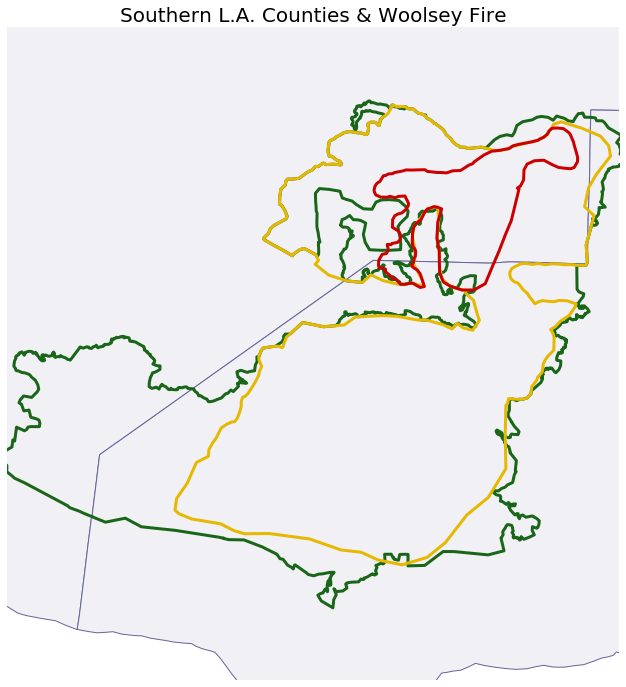

In [35]:
# zoom to bounds of largest extent of fire
min_x, min_y, max_x, max_y = map_bounds(woolsey_1118, (2/2000))
map1.gca().set_xlim(min_x, max_x)
map1.gca().set_ylim(min_y, max_y)
map1

Below, let's add in the mobile home park data to see where local mobile home parks are in relation to the fire boundaries. Luckily, the Woolsey fire did not have many casualties, though property damage was extensive.

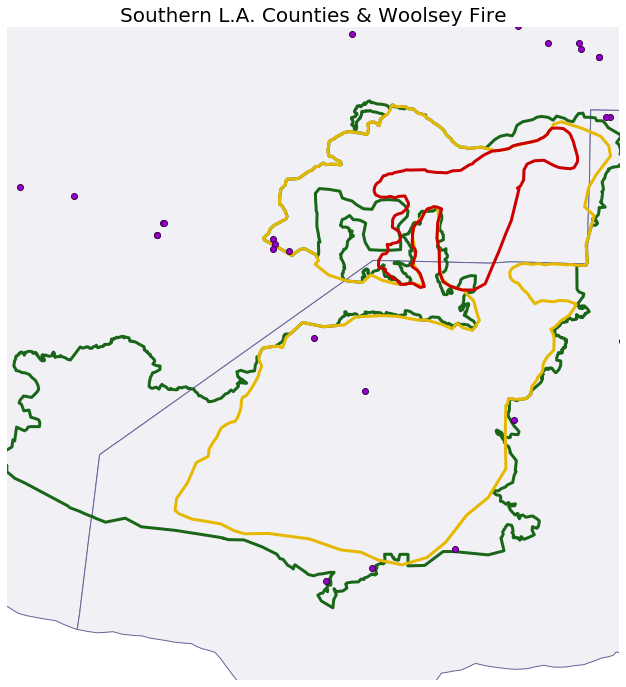

<Figure size 432x288 with 0 Axes>

In [36]:
# add mobile homes
homes.plot(ax=map1.gca(),
           color='#9900cc',
           linewidth=1.0,
           edgecolor='#39004d')
map1

We can see above that luckily the largest fire extent did not impact a large number of mobile home parks. Below, we can create a buffer around the largest fire extent to see what it might have looked like had it not been contained.

In [37]:
# let's make a buffer around the largest fire extent (11-18)
woolsey_buffer = woolsey_1118.copy()
woolsey_buffer['geometry'] = woolsey_buffer.geometry.buffer(buffer_meters(2))

In [38]:
# check out the data
woolsey_buffer

,fireName,perDatTime,geometry
0,WOOLSEY,11/18/2018 5:59:00 AM,"POLYGON ((312974.7192397863 3770361.034562325,..."


(3753489.339984119, 3801368.219499019)

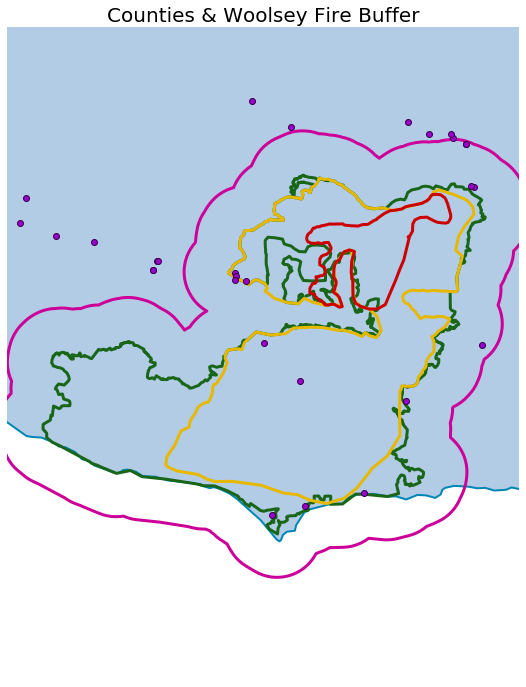

In [39]:
# create map with buffer data
map2 = plot_basic_map('Counties & Woolsey Fire Buffer')

# green boundary (2018-11-18 data, when fire contained)
woolsey_1118.plot(ax=map2.gca(),
                  color='#ffffff00',
                  linewidth=3.0,
                  edgecolor='#196619')

# yellow boundary (2018-11-10 data)
woolsey_1110.plot(ax=map2.gca(),
                  color='#ffffff00',
                  linewidth=3.0,
                  edgecolor='#e6b800')

# red boundary (2018-11-09 data, when fire started)
woolsey_1109.plot(ax=map2.gca(),
                  color='#ffffff00',
                  linewidth=3.0,
                  edgecolor='#cc0000')

# add woolsey buffer
woolsey_buffer.plot(ax=map2.gca(),
                    color='#ffffff00',
                    linewidth=3.0,
                    edgecolor='#cc0099')
# add mobile homes
homes.plot(ax=map2.gca(),
           color='#9900cc',
           linewidth=1.0,
           edgecolor='#39004d')

# zoom to bounds of fire
min_x, min_y, max_x, max_y = map_bounds(woolsey_buffer, (2/1000))
map2.gca().set_xlim(min_x, max_x)
map2.gca().set_ylim(min_y, max_y)

## Intersect Analysis of Fire Boundaries and Mobile Home Locations

Let's take a look and use an intersect analysis to find how many mobile homes are within the Woolsey fire boundary area. This will be an intersect of a single geodataframe with point data (the mobile homes) and multiple separate geodataframes with fire boundary data. 

In [40]:
# how many homes are within the woolsey_buffer area?
homes2 = gpd.sjoin(homes, woolsey_buffer, how='inner')
homes2.shape

(15, 6)

(3753489.339984119, 3801368.219499019)

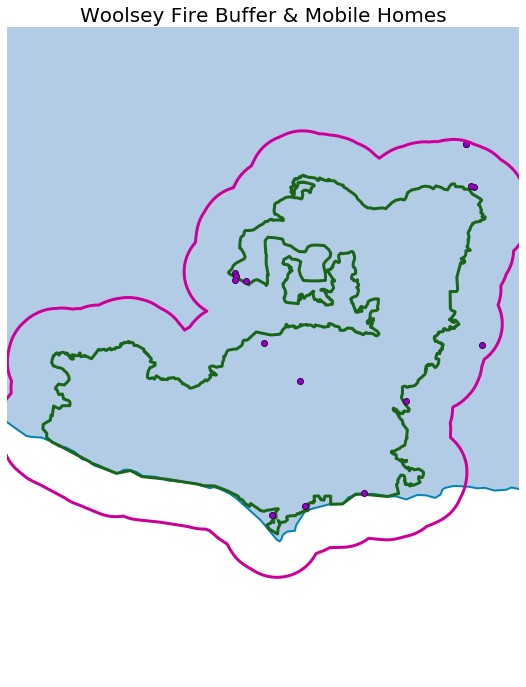

In [41]:
# create map with buffer data
map3 = plot_basic_map('Woolsey Fire Buffer & Mobile Homes')

# green boundary (2018-11-18 data, when fire contained)
woolsey_1118.plot(ax=map3.gca(),
                  color='#ffffff00',
                  linewidth=3.0,
                  edgecolor='#196619')

# add mobile homes
homes2.plot(ax=map3.gca(),
            color='#9900cc',
            linewidth=1.0,
            edgecolor='#39004d')

# add woolsey buffer
woolsey_buffer.plot(ax=map3.gca(),
                    color='#ffffff00',
                    linewidth=3.0,
                    edgecolor='#cc0099')

# set the bounds to zoom in
min_x, min_y, max_x, max_y = map_bounds(woolsey_buffer, (2/1000))
map3.gca().set_xlim(min_x, max_x)
map3.gca().set_ylim(min_y, max_y)

What if we want to know the intersection of the mobile home data and each of the other fire boundaries? Let's use a loop to do these intersects.

In [42]:
# create lists to iterate through
# join_list has all the dfs we want a spatial join for, keys_list is the labels
join_list = [woolsey_buffer, woolsey_1109, woolsey_1110, woolsey_1118]
keys_list = ['woolsey_buffer', 'woolsey_1109', 'woolsey_1110', 'woolsey_1118']

In [43]:
# iterate through dictionary
intersect_dict = {}
i=0
for layer in join_list:
    # spatial join
    join_df = gpd.sjoin(homes, layer, how='left')
    join_df = join_df[['MH_ID', 'fireName']]
    
    # check if within for this layer or not
    join_df[keys_list[i]] = join_df['fireName'].apply(lambda x: 1 if pd.notnull(x) else 0)
    join_df = join_df.drop('fireName', axis=1)    
    
    # create intersect_dict
    intersect_dict[keys_list[i]] = join_df
    i=i+1

In [44]:
# check out one of the join_df examples
join_df.head()

,MH_ID,woolsey_1118
983,6989,0
2007,5176,0
2008,5178,0
2009,5180,0
2010,5181,0


In [45]:
# check out the intersect_dict keys
intersect_dict.keys()

dict_keys(['woolsey_buffer', 'woolsey_1109', 'woolsey_1110', 'woolsey_1118'])

In [46]:
# re-arrange df into helpful format
homes_final = homes[['MH_ID', 'MH_Name']]
for key in intersect_dict.keys():
    homes_final = pd.merge(homes_final, intersect_dict[key], how='left')

In [47]:
# check out homes_final
homes_final.head(2)

,MH_ID,MH_Name,woolsey_buffer,woolsey_1109,woolsey_1110,woolsey_1118
0,6989,PIRU TRAILER CT,0,0,0,0
1,5176,LE BELLE CHATEAU ESTATES,0,0,0,0


In [51]:
# check out number of mobile homes within each buffer
homes_final.sum()

MH_ID                                                       6882336
MH_Name           PIRU TRAILER CTLE BELLE CHATEAU ESTATESBELLWOO...
woolsey_buffer                                                   15
woolsey_1109                                                      0
woolsey_1110                                                      5
woolsey_1118                                                      7
dtype: object

## Intersect Analysis of Mobile Home Locations and L.A.-Area Counties

Let's look beyond the Woolsey fire boundaries and zoom out to several counties in the surrounding area. We can use a buffer analysis to see how many mobile home parks are within 30 miles of the center of each of these counties. This will be an intersect of a single geodataframe with point data (the mobile homes) and a single separate geodataframe with multiple rows of buffer data.

In [52]:
# create county points
list(counties_cal)

['GEOID', 'NAME', 'Lat', 'Long', 'geometry']

In [53]:
# create county points dataframe
# these points represent the centroid of each county
county_points = pd.DataFrame(counties_cal) 

In [54]:
# check out the data types
county_points.dtypes

GEOID       object
NAME        object
Lat         object
Long        object
geometry    object
dtype: object

In [55]:
# convert lat & long to float so that points can be mapped
county_points['Lat'] = county_points['Lat'].astype(float)
county_points['Long'] = county_points['Long'].astype(float)

In [56]:
# turn county_points into a geodataframe
geometry = [Point(xy) for xy in zip(county_points.Long, county_points.Lat)]
county_points = county_points.drop(['Long', 'Lat'], axis=1)
crs = {'init': 'epsg:4269'} # the original crs of the counties data
gdf = gpd.GeoDataFrame(county_points, crs=crs, geometry=geometry)

In [57]:
# convert gdf to UTM zone 11
gdf = gdf.to_crs({'init': 'epsg:26911'})

In [58]:
list(gdf)

['GEOID', 'NAME', 'geometry']

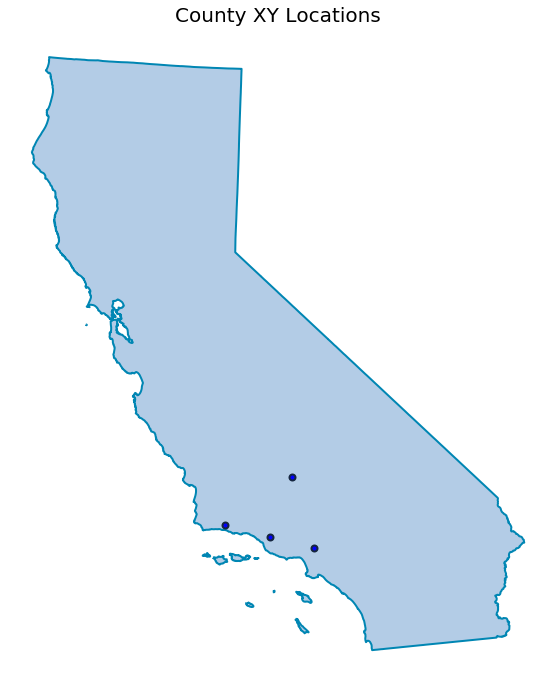

In [59]:
map4 = plot_basic_map('County XY Locations')

# now plot the county points
gdf.plot(ax=map4.gca(), 
         color='blue',
         linewidth=2,
         edgecolor='#15253f')

Now that the county centroids are plotted, let's create 30 mile buffers around each of them.

In [60]:
# create 30 mile buffer around county points
counties_buffer = gdf.copy()
counties_buffer['geometry'] = gdf.geometry.buffer(buffer_meters(30))

(3728899.147347366, 3969059.062614418)

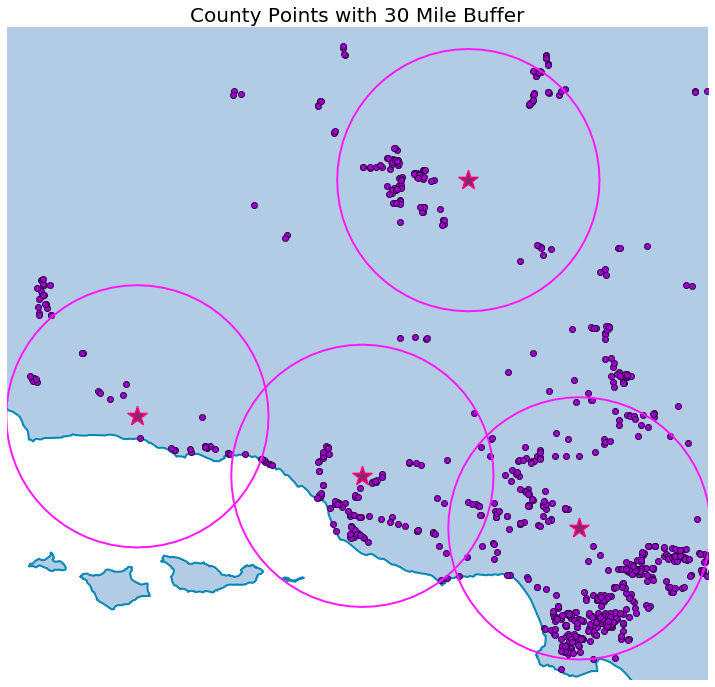

In [61]:
# map the counties & buffers
map4 = plot_basic_map('County Points with 30 Mile Buffer')

# add mobile homes
homes.plot(ax=map4.gca(),
           color='#9900cc',
           linewidth=1.0,
           edgecolor='#39004d')

# county points
gdf.plot(ax=map4.gca(), 
         color='#8f246b',
         marker='*',
         markersize=400,
         linewidth=1.5,
         edgecolor='#ff0080')

# 30 mile buffers
counties_buffer.plot(ax=map4.gca(), 
                     color='#ffffff00',
                     linewidth=2,
                     edgecolor='#ff1aff')

# set the bounds to zoom in
min_x, min_y, max_x, max_y = map_bounds(counties_buffer, (2/1000))
map4.gca().set_xlim(min_x, max_x)
map4.gca().set_ylim(min_y, max_y)

In [62]:
list(counties_buffer)

['GEOID', 'NAME', 'geometry']

In [63]:
type(counties_buffer)

geopandas.geodataframe.GeoDataFrame

What if we want to know the intersection of the mobile home data and each of these county buffers? Let's use a loop to do these intersects.

Note that this is somewhat different from the buffer intersect example above, because all of these county buffers are contained within a single geodataframe rather than multiple separate geodataframes.

In [64]:
# create a dictionary with county points
point_dict = {}

for i in range(len(counties_buffer)): # loop over the rows in geodataframe
    # select each buffer row
    buffer_row = counties_buffer.iloc[[i]] # return row as a geodataframe
    buffer_row_name = buffer_row['NAME'].iloc[0]

    # now do a join from homes to just this buffer
    join_buffer = gpd.sjoin(homes, buffer_row, how='left')
    
    # check if within for this layer or not
    join_buffer[buffer_row_name] = join_buffer['GEOID'].apply(lambda x: 1 if pd.notnull(x) else 0)
    join_buffer = join_buffer[['MH_ID', buffer_row_name]]
    
    # add to dictionary
    point_dict[buffer_row_name] = join_buffer

In [65]:
# check out the join_buffer
join_buffer.head()

,MH_ID,Kern
983,6989,0
2007,5176,0
2008,5178,0
2009,5180,0
2010,5181,0


Finally, let's re-arrange the data so that it's in an easy-to-interpret format. This final dataframe includes a row for each mobile home, and a column for each of the counties. Within each county column, each row has a 0 or 1, with a 1 indicating that that specific mobile home falls within 30 miles of the county centroid.

In [66]:
# make a copy of homes and re-arrange df
homes_final = homes.copy()
for key in point_dict.keys():
    homes_final = pd.merge(homes_final, point_dict[key], how='left')

In [67]:
homes_final.shape

(968, 7)

In [68]:
homes_final.head()

,MH_ID,MH_Name,geometry,Santa Barbara,Ventura,Los Angeles,Kern
0,6989,PIRU TRAILER CT,POINT (334832.1290723266 3809757.1404938),0,1,0,0
1,5176,LE BELLE CHATEAU ESTATES,POINT (399882.917734686 3746785.603816534),0,0,1,0
2,5178,BELLWOOD MHP,POINT (396661.4600033994 3750584.015065907),0,0,1,0
3,5180,BELL OAKS TP,POINT (394898.5800335355 3748837.871738015),0,0,1,0
4,5181,3 RS TP,POINT (395063.0973148603 3748836.713456928),0,0,1,0


In [69]:
point_dict.keys()

dict_keys(['Santa Barbara', 'Ventura', 'Los Angeles', 'Kern'])

In [70]:
list(homes_final)

['MH_ID',
 'MH_Name',
 'geometry',
 'Santa Barbara',
 'Ventura',
 'Los Angeles',
 'Kern']

In [71]:
# check out the count of buffer intersects
# i.e. -- how many homes are within 0 of the buffers, 1 of the buffers, 2 of the buffers, etc.
homes_final['sum_intersect'] = homes_final[list(point_dict.keys())].sum(axis=1)
homes_final['sum_intersect'].value_counts()

1    801
0    155
2     12
Name: sum_intersect, dtype: int64